In [170]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom
import astropy.table as astTable
import fitsio
import glob
import lsst.afw.image as afwImage
import anacal
from astropy.visualization import ZScaleInterval
import re

from xlens.process_pipe.anacal_detect import AnacalDetectPipeConfig, AnacalDetectPipe
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

In [367]:
config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.num_epochs = 8
config.anacal.num_epochs_deblend = 1
config.anacal.use_average_psf = False
badMaskPlanes = [
    'BAD', 'CR', 'CROSSTALK', 'NO_DATA', 'REJECTED', 'SAT', 
    'SUSPECT', 'UNMASKEDNAN', 'SENSOR_EDGE', 'STREAK', 'VIGNETTED', 
    'INTRP', 'EDGE', 'CLIPPED', 'INEXACT_PSF',
]
config.anacal.badMaskPlanes = badMaskPlanes
task = AnacalDetectPipe(config=config)

import lsst.afw.table as afwtable

def extract_boxes(filename):
    pattern = re.compile(
        r"box\((?P<ra>\d*\.?\d+),\s*"
        r"(?P<dec>-?\d*\.?\d+),\s*"
        r"(?P<width>\d*\.?\d+)d,\s*"
        r"(?P<height>\d*\.?\d+)d,\s*"
        r"(?P<angle>-?\d*\.?\d+)\)\s*"
        r"# ID: (?P<id>\d+), mag: (?P<mag>\d*\.?\d+)"
    )

    ra_list = []
    dec_list = []
    width_list = []
    height_list = []
    angle_list = []
    id_list = []
    mag_list = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            match = pattern.match(line)
            if match:
                ra_list.append(float(match.group("ra")))
                dec_list.append(float(match.group("dec")))
                width_list.append(float(match.group("width")))
                height_list.append(float(match.group("height")))
                angle_list.append(float(match.group("angle")))
                id_list.append(int(match.group("id")))
                mag_list.append(float(match.group("mag")))

    return astTable.Table(
        [ra_list, dec_list, width_list, height_list, angle_list, id_list, mag_list],
        names=("ra", "dec", "width", "height", "angle", "id", "mag")
    )


def extract_circles(filename):
    pattern = re.compile(
        r"circle\((?P<ra>\d*\.?\d+),\s*"
        r"(?P<dec>-?\d*\.?\d+),\s*"
        r"(?P<r>\d*\.?\d+)d\)\s*"
        r"# ID: (?P<id>\d+), mag: (?P<mag>\d*\.?\d+)"
    )

    ra_list = []
    dec_list = []
    r_list = []
    id_list = []
    mag_list = []

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line.startswith("circle("):
                continue

            match = pattern.match(line)
            if match:
                ra_list.append(float(match.group("ra")))
                dec_list.append(float(match.group("dec")))
                r_list.append(float(match.group("r")))
                id_list.append(int(match.group("id")))
                mag_list.append(float(match.group("mag")))

    out = astTable.Table(
        [ra_list, dec_list, r_list, id_list, mag_list],
        names=("ra", "dec", "r", "id", "mag")
    )
    out = out[out["r"] != 0.011111]
    return out

def get_mask(skymap, badMaskPlanes, entry):
    tract_id = entry["tract"]
    patch_db = entry["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    patch_id = patch_x + patch_y * 9
    patch_info = skymap[tract_id][patch_id]
    wcs = patch_info.getWcs()
    bbox = patch_info.getOuterBBox()
    image_dir = (
        "/lustre/HSC_DR/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_calexp"
    )
    files = glob.glob(os.path.join(image_dir, f"{tract_id}/{patch_id}/i/*"))
    fname = files[0]
    exposure = afwImage.ExposureF.readFits(fname)
    bitValue = exposure.mask.getPlaneBitMask(badMaskPlanes)
    mask_array = (
        ((exposure.mask.array & bitValue) != 0)
        | (
            exposure.image.array
            < (
                -6.0
                * np.sqrt(
                    np.where(
                        exposure.variance.array < 0, 0, exposure.variance.array
                    )
                )
            )
        )
    ).astype(np.int16)
    
    mask_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/BrightObjectMasks/"
    mask_fname = os.path.join(mask_dir, f"{tract_id}/BrightObjectMask-{tract_id}-{patch_x},{patch_y}-HSC-I.reg")
    
    ddc = extract_circles(mask_fname)
    x, y = wcs.skyToPixelArray(ra=ddc["ra"], dec=ddc["dec"], degrees=True)
    x = np.array(x - bbox.getBeginX(), dtype=float)
    y = np.array(y - bbox.getBeginY(), dtype=float)
    # Angular diameter distance at z
    r = ddc["r"] * 3600 / 0.168

    nx = bbox.getWidth()
    ny = bbox.getHeight()
    msk = (x+r > 0) & (x-r < nx) & (y+r > 0) & (y-r < ny)
    x = x[msk]
    y = y[msk]
    r = r[msk]
    
    dtype = np.dtype([("x", float), ("y",float), ("r", float)])
    xy_r = np.zeros(len(x), dtype=dtype)
    xy_r["x"] = x
    xy_r["y"] = y
    xy_r["r"] = r
    anacal.mask.add_bright_star_mask(mask_array=mask_array, star_array=xy_r)
    
    cat_dir = "/lustre/HSC_DR/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_meas"
    band = "i"
    files = glob.glob(os.path.join(cat_dir, f"{tract_id}/{patch_id}/{band}/*"))
    cat =  afwtable.SourceCatalog.readFits(files[0])
    snr = cat["base_CircularApertureFlux_3_0_instFlux"] / cat["base_CircularApertureFlux_3_0_instFluxErr"]
    mm = (cat["base_PixelFlags_flag_saturated"]) & (snr > 80) & (cat["deblend_nChild"] ==0) 
    cat = cat[mm]
    x = cat["base_SdssCentroid_x"] - bbox.getBeginX()
    y = cat["base_SdssCentroid_y"] - bbox.getBeginY()
    r = np.sqrt(cat["base_FootprintArea_value"]) * 1.1
    xy_r = np.zeros(len(x), dtype=dtype)
    xy_r["x"] = x
    xy_r["y"] = y
    xy_r["r"] = r
    anacal.mask.add_bright_star_mask(mask_array=mask_array, star_array=xy_r)
    
    ddb = extract_boxes(mask_fname)
    x, y = wcs.skyToPixelArray(ra=ddb["ra"], dec=ddb["dec"], degrees=True)
    x = np.array(x - bbox.getBeginX(), dtype=float)
    y = np.array(y - bbox.getBeginY(), dtype=float)
    w = ddb["width"] * 3600 / 0.168
    h = ddb["height"] * 3600 / 0.168
    msk = (x+w / 2 > 0) & (x- w/2 < bbox.getWidth()) & (y+h/2 > 0) & (y-h/2 < bbox.getHeight())
    x = x[msk]
    y = y[msk]
    w = w[msk]
    h = h[msk]
    nbox = len(x)
    for i in range(nbox):
        xmin = int(min(max(x[i] - w[i] / 2, 0), nx))
        xmax = int(min(max(x[i] + w[i] / 2, 0), nx))
        ymin = int(min(max(y[i] - h[i] / 2, 0), ny))
        ymax = int(min(max(y[i] + h[i] / 2, 0), ny))
        if ((xmin < xmax) & (ymin < ymax)):
            mask_array[ymin: ymax, xmin: xmax] = 1
    return mask_array

In [354]:
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/image'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
skymap = obs_butler.get('skyMap', skymap="hsc")
db_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/"

In [375]:
full = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim5.fits")
entry = full[0]

In [376]:
image_dir = (
    "/lustre/HSC_DR/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_calexp"
)
tract_id = entry["tract"]
patch_db = entry["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_id = patch_x + patch_y * 9
patch_info = skymap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()
files = glob.glob(os.path.join(image_dir, f"{tract_id}/{patch_id}/i/*"))
fname = files[0]
exposure = afwImage.ExposureF.readFits(fname)
seed = tract_id * 1000 + patch_id
data = task.anacal.prepare_data(
    exposure=exposure,
    seed=seed,
    noise_corr=None,
    detection=None,
    band=None,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
)
catalog = task.anacal.run(**data)

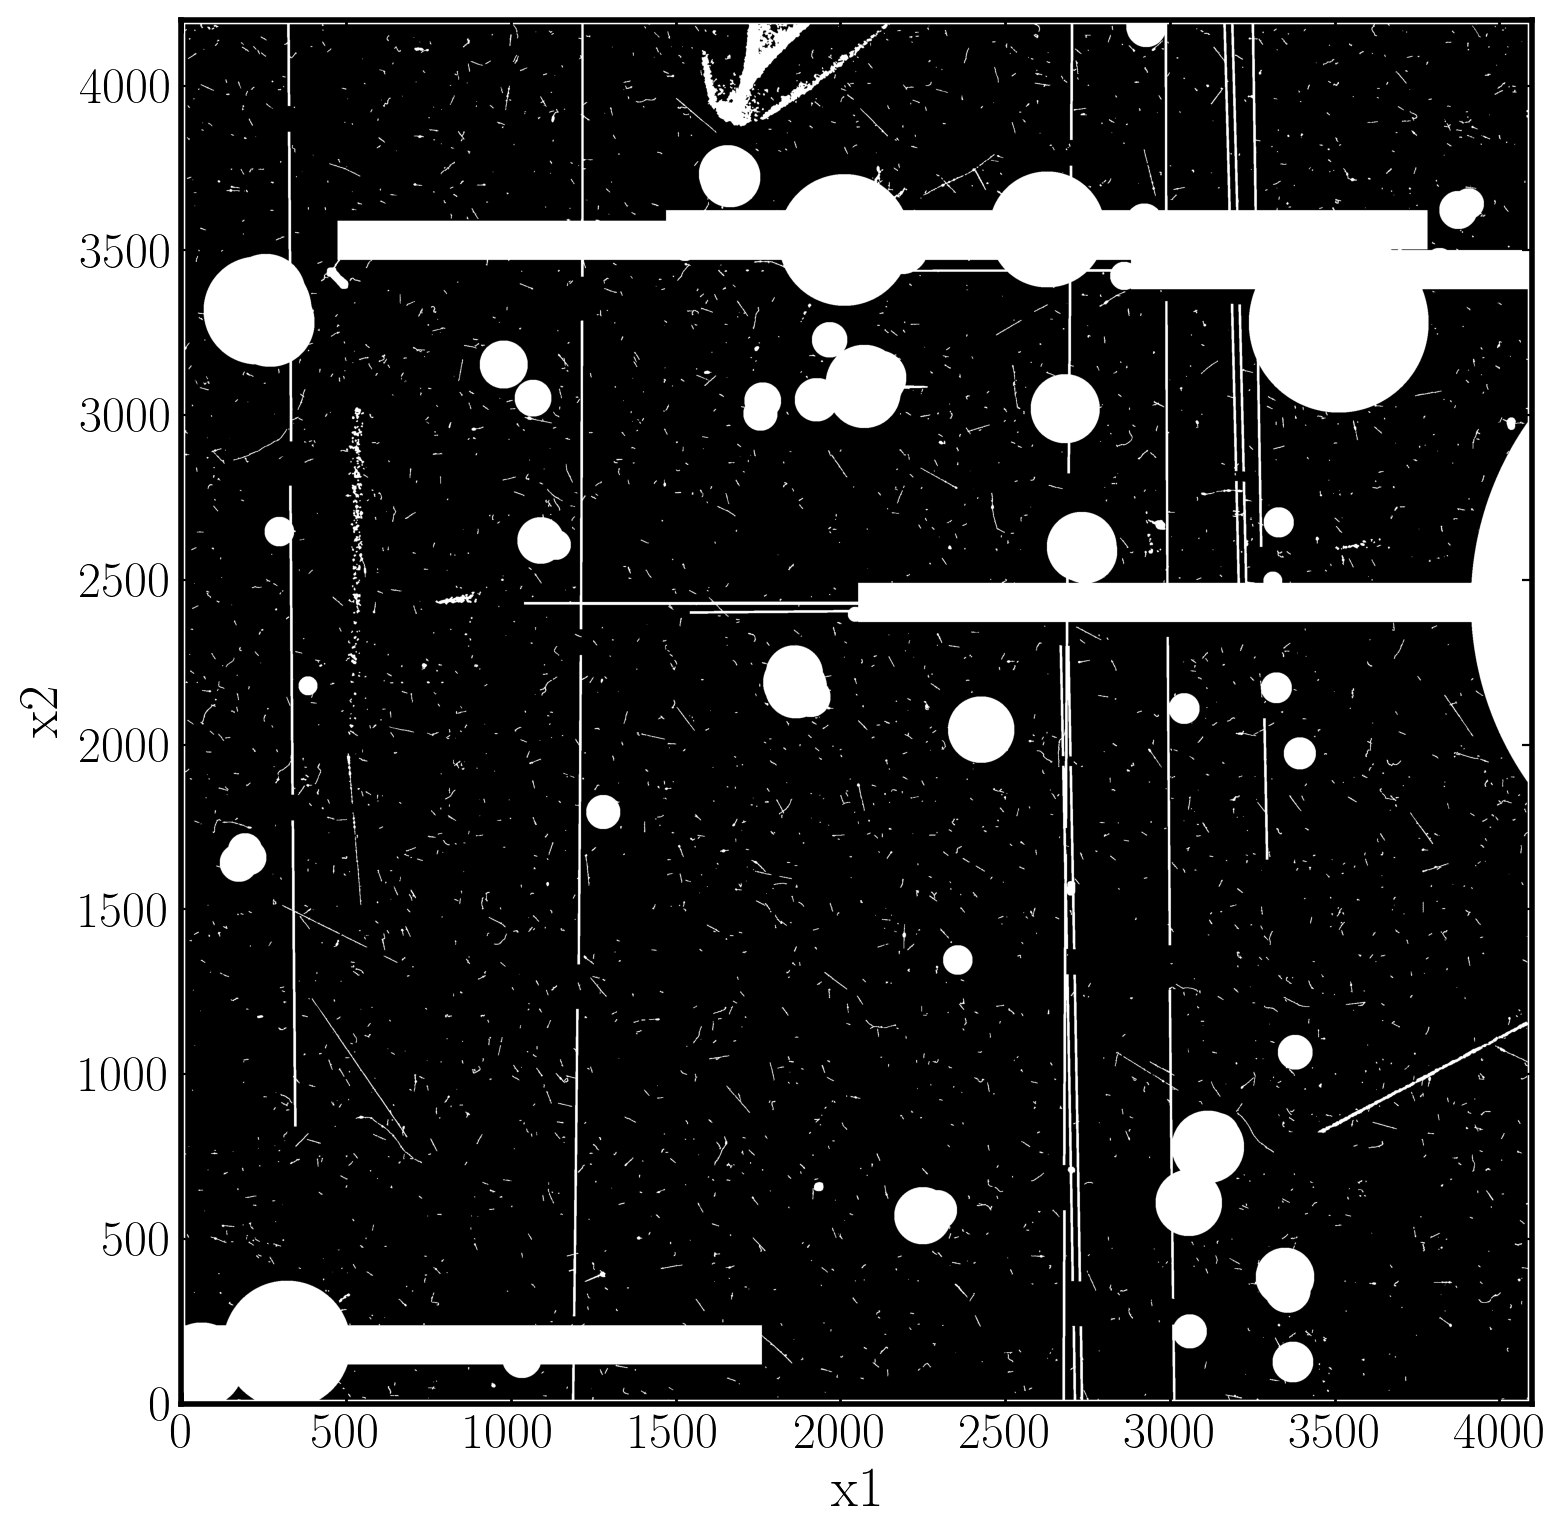

In [377]:
mask_array = get_mask(skymap, badMaskPlanes, entry)
image = mask_array
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray')

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

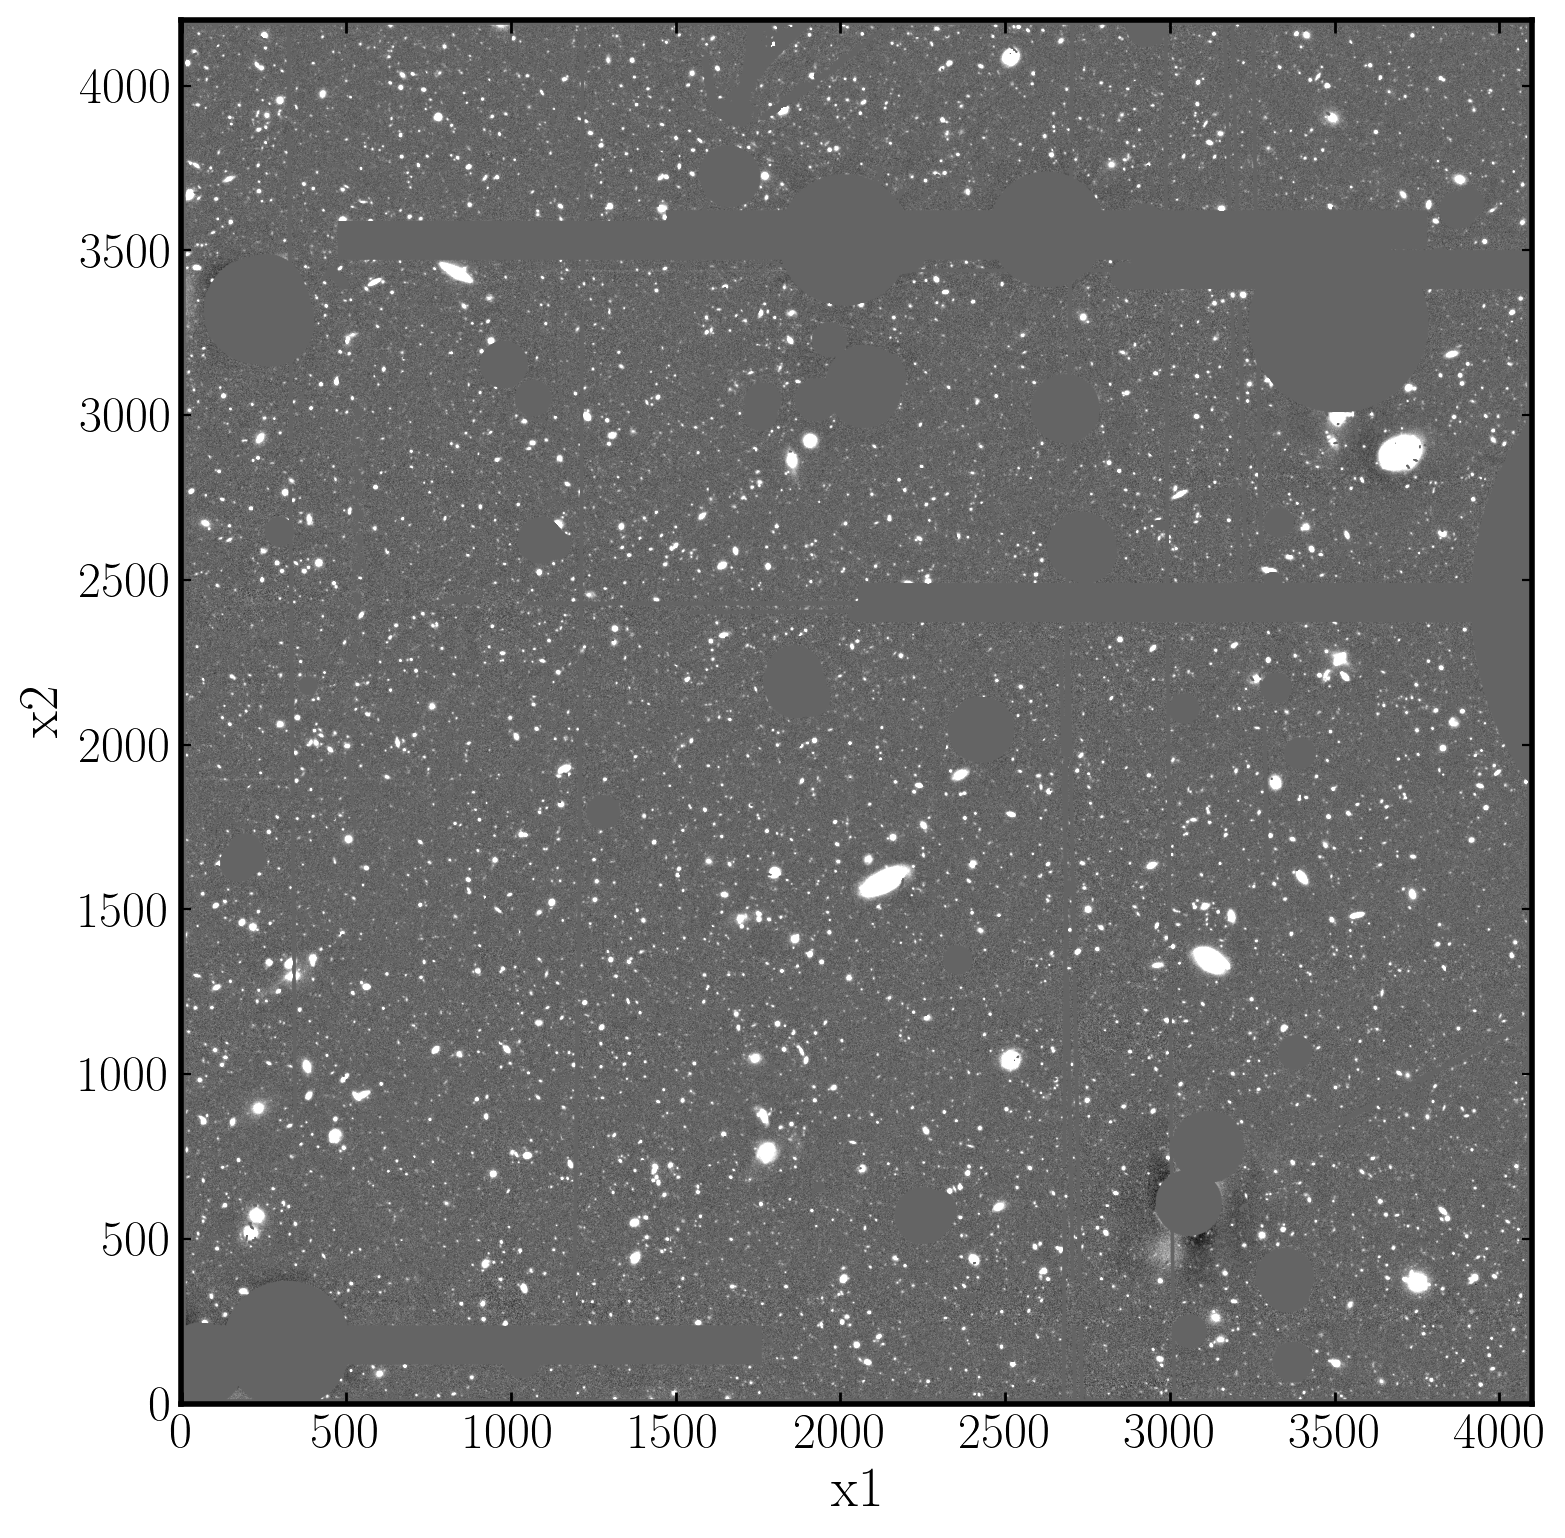

In [378]:
# Example inputs: replace with your actual data
image = data["gal_array"] * (mask_array - 1.0) * -1.0
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

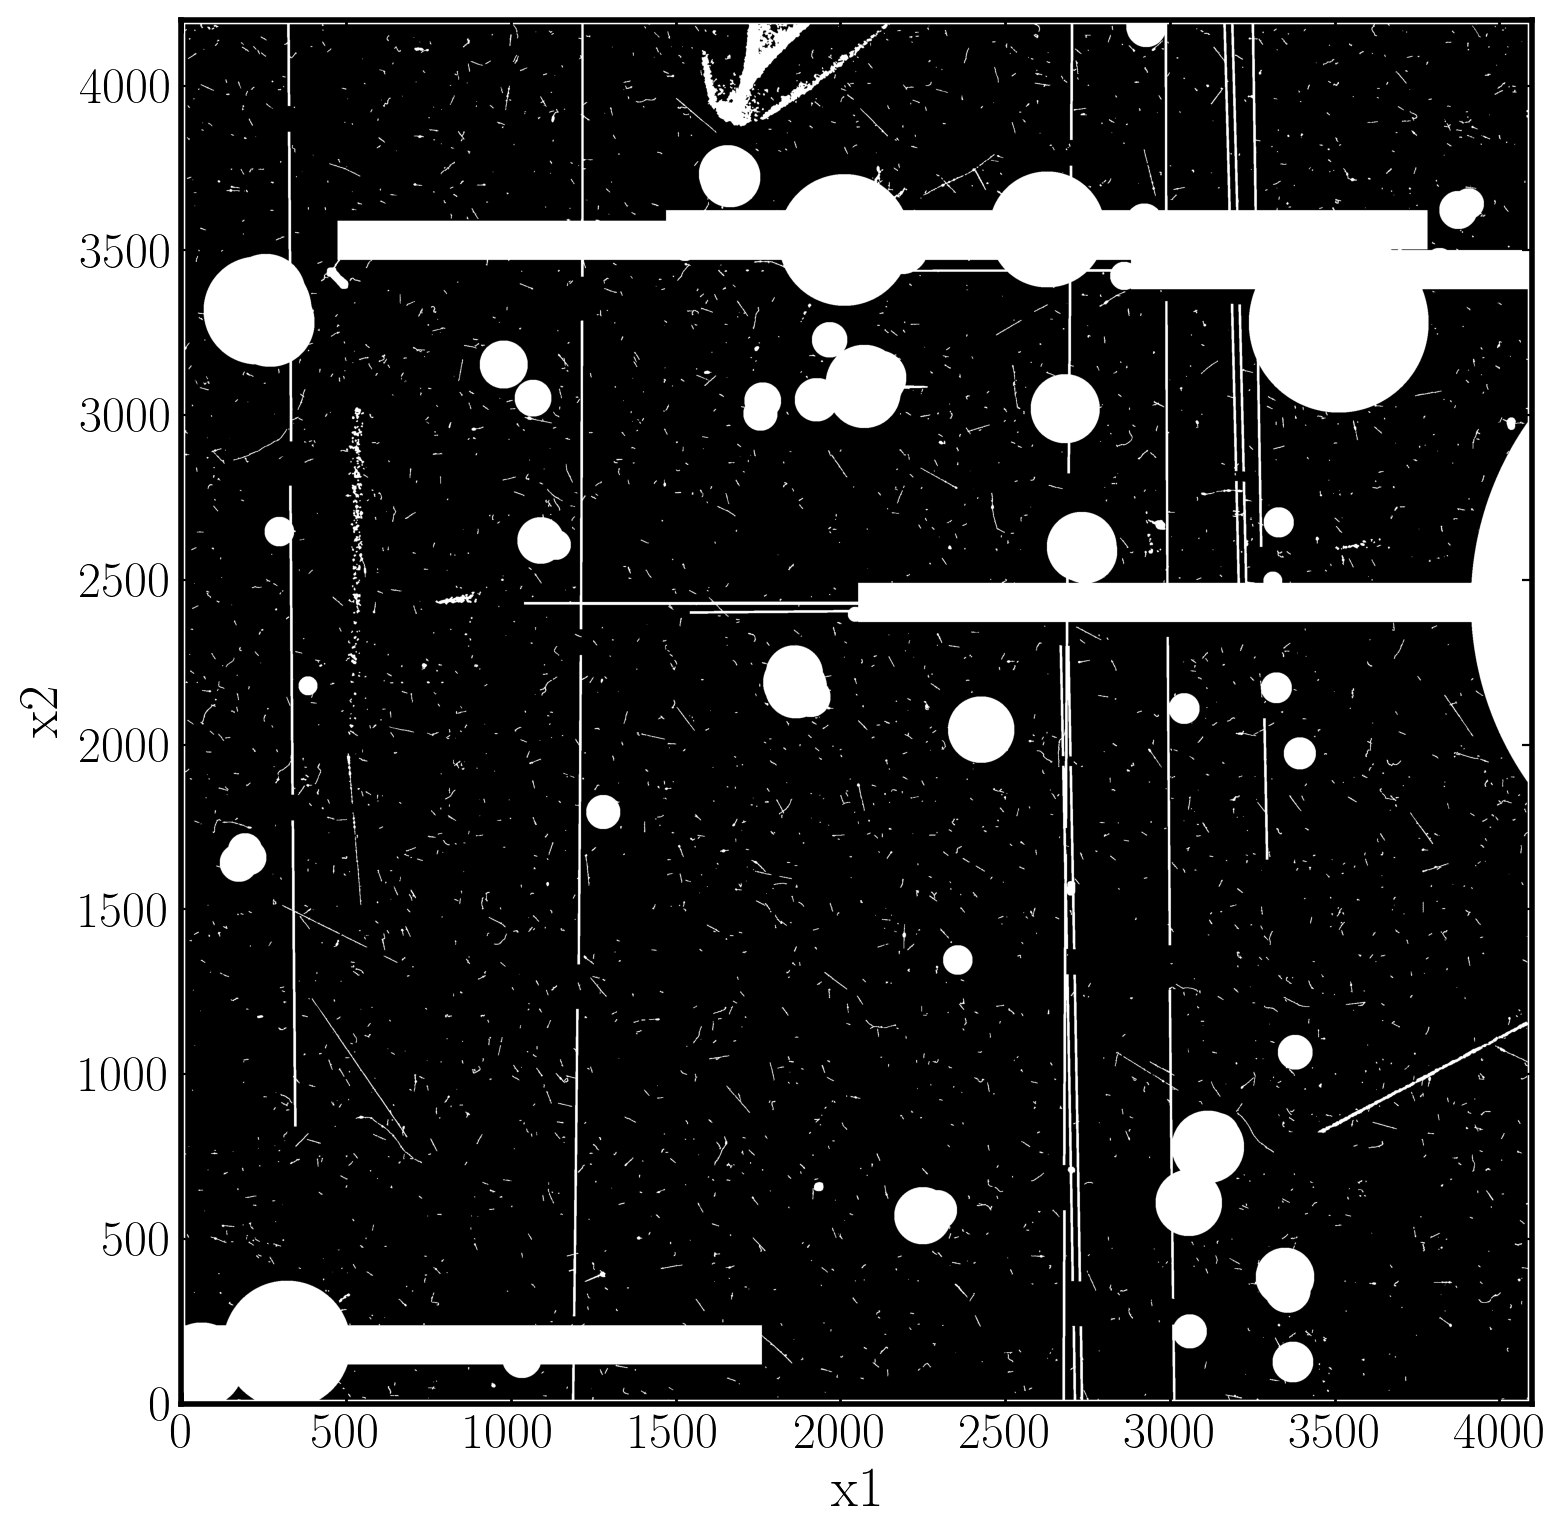

In [379]:
msk_fname = f"/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-brightStarMask/tracts_mask/{tract_id}/{patch_id}/mask.fits"
image = fitsio.read(msk_fname)

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray')

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()